### Train a Simple Classifier

In our first session we learned about training a classifier on the MNIST Images. The thing about MNIST though is the dataset is very simple! Today we will repeat this, but with a slightly more complex dataset known as CIFAR10 using Convolution Neural Network (CNN).



In [72]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


### Lets Explore the Data

We will load the data here, lets take a quick look at what it looks like!

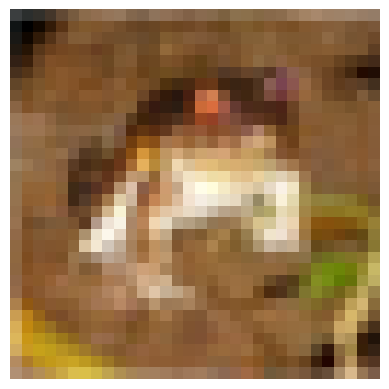

In [73]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

sample, label = next(iter(trainset))

plt.imshow(np.array(sample))
plt.axis("off")
plt.show()

Thats a Frog! Just like MNIST there are 10 classes of images that we need to classify between!

### Define a Model

You can use any model shape you want, just use Linear layers only though. This means you can test how many hidden nodes to have in intermediate layers, and also how many layers you want in total. You can also play with different activation functions to see what works better!

In [74]:
# 2-layer CNN with Batch Normalization
class SimpleCNN2(nn.Module):
    def __init__(self):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride = 1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride = 1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# 3-layer CNN
class SimpleCNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x    


model = SimpleCNN3()


Check what the first convolutional layer looks like

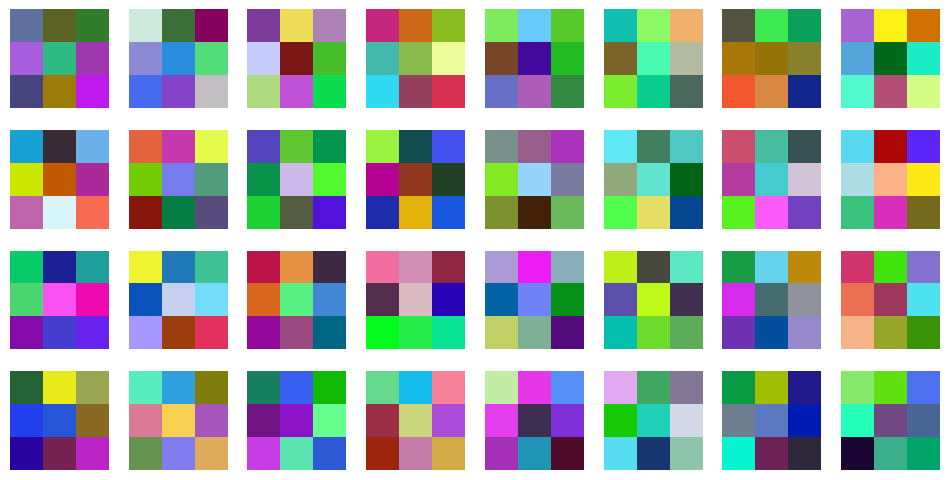

In [49]:
import matplotlib.pyplot as plt

# Get the weights from the first conv layer
filters = model.conv1.weight.data.clone()

# Normalize for visualization
filters = (filters - filters.min()) / (filters.max() - filters.min())

fig, axes = plt.subplots(4, 8, figsize=(12,6))
for i, ax in enumerate(axes.flat):
    if i < filters.shape[0]:
        # Show each filter as an image
        ax.imshow(filters[i].permute(1, 2, 0))  # (C, H, W) -> (H, W, C)
        ax.axis('off')
plt.show()


### Define a Dataloader

We Now need to prepare our dataloader with the batch size we want to train with! I provide the datasets here (with some simple image transforms such as converting PIL to tensor and then normalizing). Create the dataloaders from that!

In [76]:
# add data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

BATCH_SIZE = 128
# shuffle is to randomize the order of the data to avoid overfitting
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)



### Train a Model

Train your model for however many epochs you want. Make sure to calculate the average loss and accuracy per epoch for both the training set and evaluation set so we can plot our training curves after!

Things we need to set:

- Device
- Loss Function (what loss do we use for classification?)
- Optimizer (you can use whatever you want, and whatever learning rate you want)

In [78]:
### Set the Device ###
device = "cuda" if torch.cuda.is_available() else "cpu"

### Set the Loss Function ###
criterion = nn.CrossEntropyLoss()

### Set the Optimizer ###
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Store metrics ###
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

### Training Loop ###
epochs = 20
for epoch in range(epochs):
# for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(trainloader)
    train_accuracy = 100.0 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    val_loss = val_running_loss / len(testloader)
    val_accuracy = 100.0 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/20, Train Loss: 1.4176, Train Accuracy: 48.14%, Val Loss: 1.2490, Val Accuracy: 56.35%
Epoch 2/20, Train Loss: 1.0433, Train Accuracy: 62.63%, Val Loss: 1.0524, Val Accuracy: 62.76%
Epoch 3/20, Train Loss: 0.9134, Train Accuracy: 67.80%, Val Loss: 0.9035, Val Accuracy: 67.97%
Epoch 4/20, Train Loss: 0.8311, Train Accuracy: 70.66%, Val Loss: 0.8679, Val Accuracy: 70.05%
Epoch 5/20, Train Loss: 0.7764, Train Accuracy: 72.59%, Val Loss: 0.8360, Val Accuracy: 70.43%
Epoch 6/20, Train Loss: 0.7299, Train Accuracy: 74.50%, Val Loss: 0.7926, Val Accuracy: 72.19%
Epoch 7/20, Train Loss: 0.6913, Train Accuracy: 75.86%, Val Loss: 0.7076, Val Accuracy: 75.18%
Epoch 8/20, Train Loss: 0.6646, Train Accuracy: 76.71%, Val Loss: 0.7354, Val Accuracy: 74.97%
Epoch 9/20, Train Loss: 0.6380, Train Accuracy: 77.76%, Val Loss: 0.6498, Val Accuracy: 77.66%
Epoch 10/20, Train Loss: 0.6190, Train Accuracy: 78.24%, Val Loss: 0.6559, Val Accuracy: 76.74%
Epoch 11/20, Train Loss: 0.6038, Train Accuracy: 

### Plot Loss and Accuracy

Baseline configuration: 2 layer CNN, no augmentation

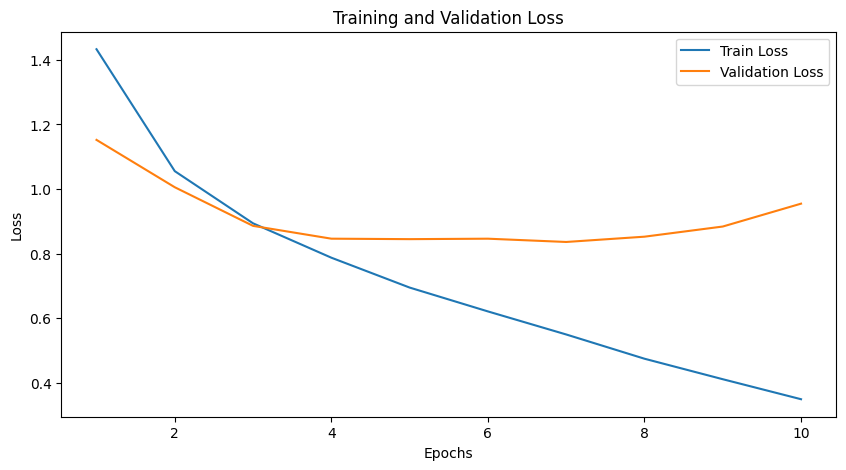

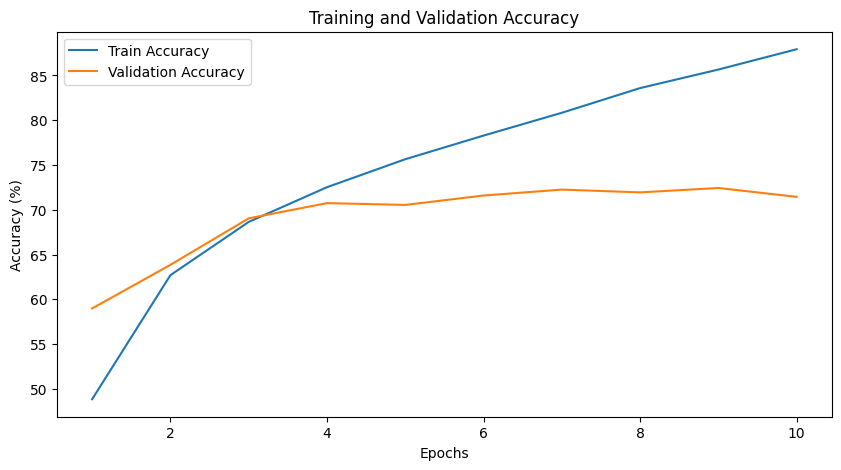

In [8]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

Using Batch Normalization

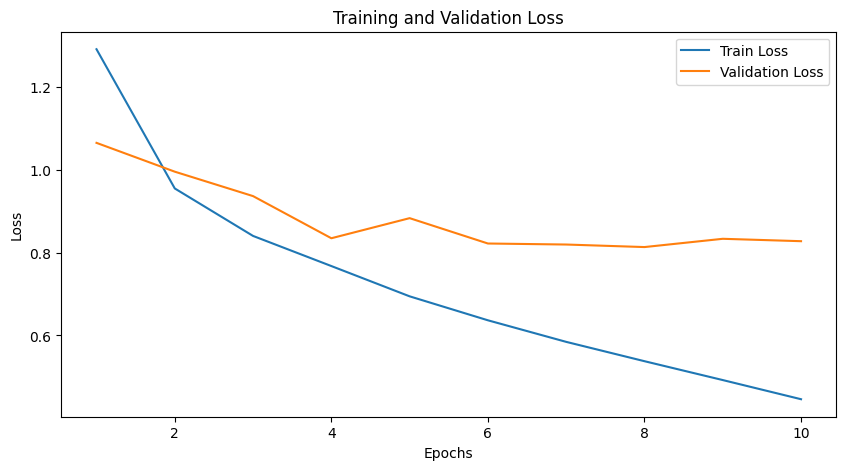

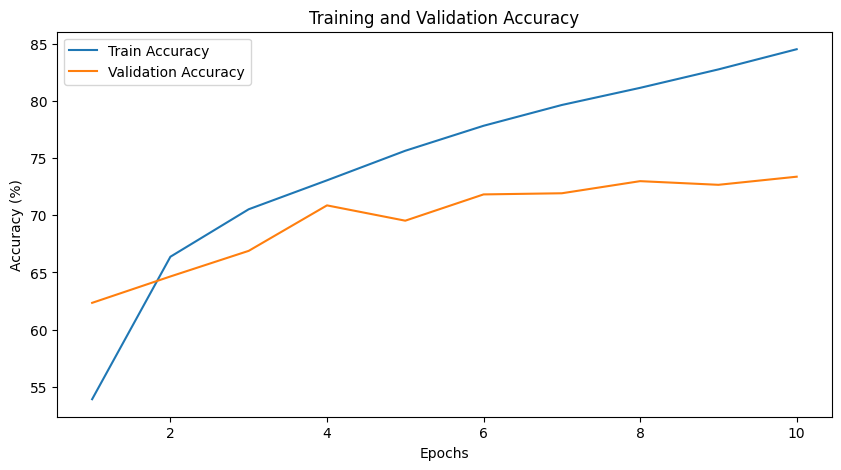

In [40]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

3-layer CNN

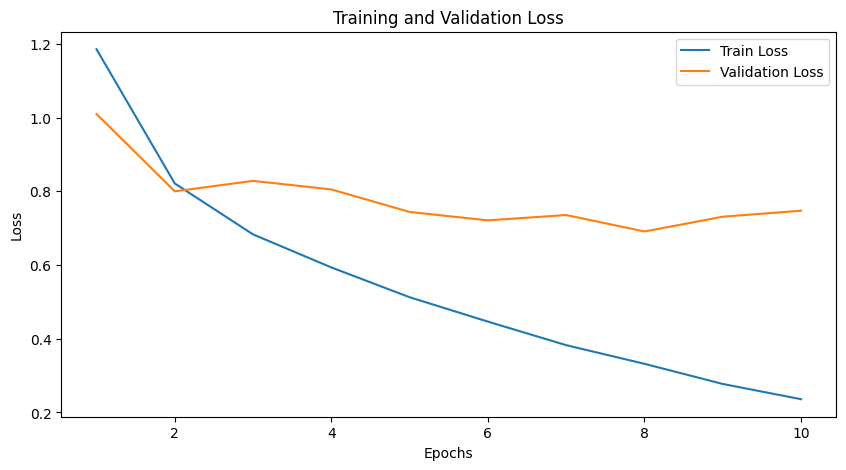

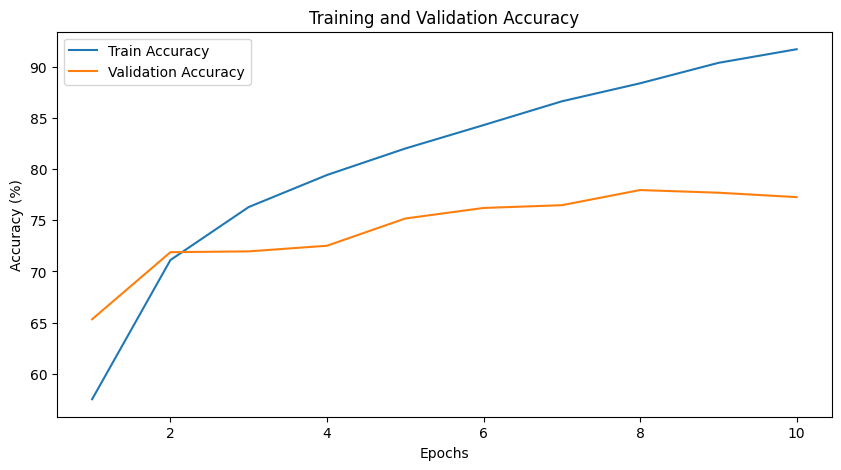

In [45]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

3-layer CNN + data augmentation:
overfitting is gone, but the accuracy of the training model is reduced a bit. Data augmentation makes my training data more diverse and challenging by introducing random transformations, this means the model sees a slightly different version of each image every epoch, making the training task harder, hence the accuracy drops. This motivates me to run a larger epoch to overcome the low accuracy.

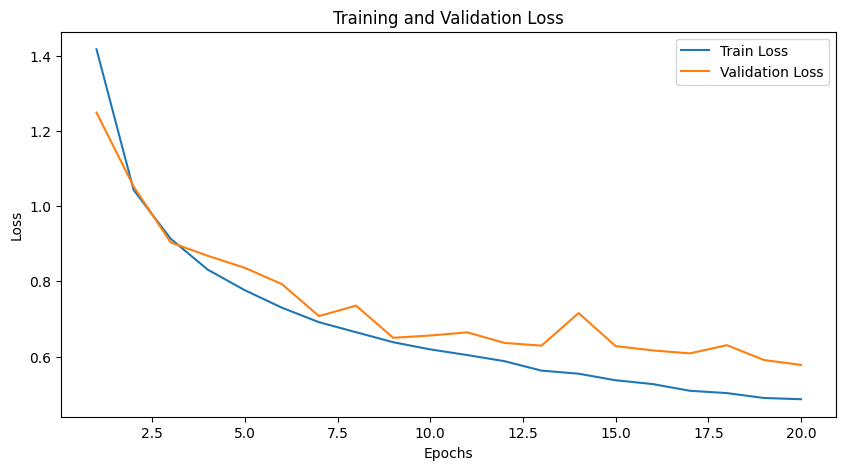

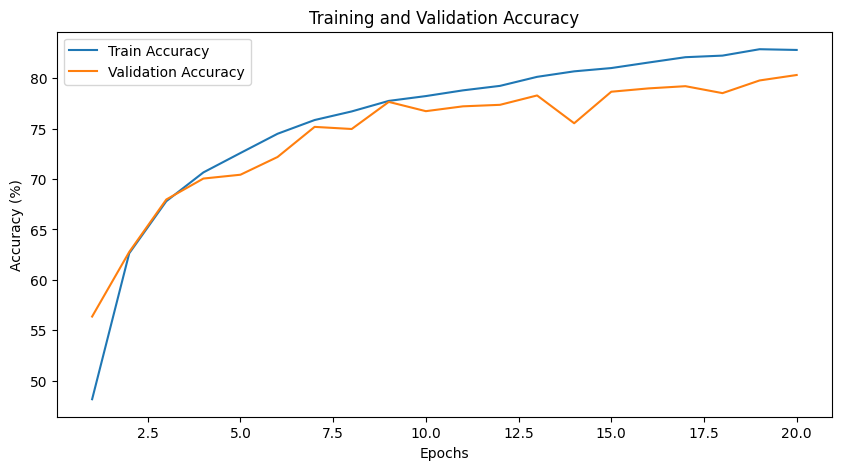

In [79]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

Conclusions from this exercise: 

Depths of CNN layers: 

$\bullet$ increase depth: additional convolutional layer allows the network to learn more complex and abstract features. Potential for higher accuracy but increased risk of overfitting and takes more time. 

$\bullet$ decrease the depth:
less abstraction potential underfitting.

Channels: 

$\bullet$ More channels give more features/filters, so accuracy is higher, but is slower and more prone to overfitting because the model can memorize the patterns

$\bullet$ Fewer channels: less capacity to learn diverse features and lead to lower accuracy. It is faster when training but may underfit if the model is too simple.